In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math
import time
from PIL import Image

In [2]:
# (Optional): Initilize device
'''

if torch.backends.cuda.is_available():
    device = torch.device("cuda")
else:
    device=torch.device("cpu")
'''

device=torch.device("cpu")

# Global parameters and numerical implementation of the van der Pol oscillator

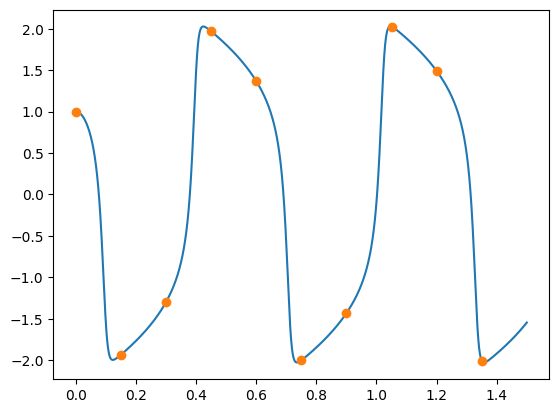

In [3]:
# NN model parameters
hidden_size=25
hidden_depth=4
n_data=10
n_input=1
n_output=1


np.random.seed(1234)

# ODE solution and parameters ("ground truth")
T_end=1.5
epsilon=50
dt=0.0001
time_numeric=np.linspace(0,T_end,round(T_end/dt),dtype=np.float32)

# ODE integrator
def van_der_pol(T_end):
    y_0=np.array([1.0,0.],np.float32)
    steps=round(T_end/dt)
    sol=np.array([y_0],np.float32)
    # Euler method to solve ODE
    for i in range(steps-1):
        y=y_0+dt*np.array([y_0[1],epsilon*(1-(y_0[0])**2)*y_0[1]-((15.0)**2)*y_0[0]],np.float32)
        sol=np.append(sol,[y],axis=0)
        y_0=y
        
    return sol[:,0]

y_exact=van_der_pol(T_end)

# Generate inputs and outputs for NN training
y_out=torch.from_numpy(y_exact[0:-1:1500]).reshape(-1,1)
y_out=y_out+0*torch.normal(0,1,y_out.shape)
t=torch.from_numpy(time_numeric[0:-1:1500])
t=t.reshape(-1,1)

# Collocation points for PINNS
t_coll=torch.linspace(0,T_end,500,dtype=torch.float32).reshape(-1,1)

# Plot numerical solution and data points
plt.plot(time_numeric,y_exact)
plt.plot(t,y_out,'o')
plt.show()

# Neural network architecture (FCN in PyTorch)

In [4]:
# Fully-connected neural network with variable number of hidden layers and neurons
    

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_depth, num_classes):
        super().__init__()
        # Activation function
        self.activation=nn.Tanh()
        # Module list for NN
        self.layers=nn.ModuleList()

        # Model parameters for inference task
        self.epsilon = nn.Parameter(torch.tensor(30.,dtype=torch.float32))
        
        #add input layer
        self.layers.append(nn.Linear(input_size,hidden_size))
        #add activation for input layer
        self.layers.append(self.activation)
        for i in range(hidden_depth-1):
            self.layers.append(nn.Linear(hidden_size,hidden_size))
            self.layers.append(self.activation)

        self.layers.append(nn.Linear(hidden_size,num_classes))

        # Initilize weights
        for i in range(2*hidden_depth): 
            if i % 2 ==0:
                nn.init.xavier_normal_(self.layers[i].weight.data, gain=1.0)
                nn.init.zeros_(self.layers[i].bias.data)
                           

   
    def forward(self, x):
        for layer in self.layers:
            x=layer(x)
            
        return x



torch.manual_seed(12363)
model = NeuralNet(n_input, hidden_size, hidden_depth,n_output).to(device)

# Custom PyTorch class for PINNs and data loss functions

In [5]:
# input tensor must have requires_grad=True!

class physics_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse=nn.MSELoss(reduction='mean')

    def forward(self,t):

        return model(t)

    def physics(self,t_ph):
        t_coll=t_ph.clone()
        t_coll.requires_grad=True
        y_pred_physics=self.forward(t_coll)
        dydt=torch.autograd.grad(y_pred_physics,t_coll,grad_outputs=torch.ones_like(y_pred_physics),create_graph=True)[0]
        d2ydt2=torch.autograd.grad(dydt,t_coll,grad_outputs=torch.ones_like(dydt),create_graph=True)[0]
        # f is the residual and is used to determine the physics loss function
        f=d2ydt2-model.epsilon*(1-y_pred_physics**2)*dydt+15.0**2*y_pred_physics
        
        return torch.mean(f**2)+(dydt[0,0])**2

    def bc(self,t_ph_bc):
        t_coll_bc=t_ph_bc.clone()
        t_coll_bc.requires_grad=True
        y_pred_physics_bc=self.forward(t_coll_bc)
        dydt_bc=torch.autograd.grad(y_pred_physics_bc,t_coll_bc,grad_outputs=torch.ones_like(y_pred_physics_bc),create_graph=True)[0]

        return (dydt_bc[0,0])**2

    def data_loss(self,y,t_data):
        prediction=self.forward(t_data)

        return self.mse(y,prediction)
    

# Definition of optimizer (combination of Adam and L-BFGS)

## We use dynamic weighting of loss functions (sequential learning) to optimize the network

In [6]:
#initiate loss function and optimizer

learning_rate=1e-3
loss_function=physics_loss()


#LBFGS optimizer:
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=1e-1,max_iter=50000,max_eval=None,tolerance_grad=1e-11,tolerance_change=1e-11,history_size=200,line_search_fn="strong_wolfe")

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# Dynamic weighting functions

def dynamicweighting_absvalue(loss):
    layers={}
    loss_func=loss.clone()
    gradient = torch.autograd.grad(loss_func,model.parameters(),retain_graph=True,allow_unused=True)
    with torch.no_grad():
        for idx, param_grad in enumerate(gradient):
            if idx!=0:
                layers[f'layer_{idx}']=torch.sum(param_grad**2)

    return torch.sqrt(sum(layers.values()))

# Training the PINNs model

In [7]:
start_time = time.time()

n_Training=10000
lmbda_d=torch.tensor(1.)
lmbda_bc=torch.tensor(1.)
alpha=torch.tensor(0.7)
iter=0

# Optimization with Adam
for epoch in range(n_Training+1):

    optimizer.zero_grad()
    loss_function_ph=loss_function.physics(t_coll)
    loss_d=loss_function.data_loss(y_out,t)     
    if epoch % 5 == 0:          
        lamb_ph=dynamicweighting_absvalue(loss_function_ph)
        lamb_d=dynamicweighting_absvalue(loss_d)
        dynamicweight_d=lamb_ph/lamb_d
        lmbda_d=(1.-alpha)*lmbda_d+alpha*dynamicweight_d
        
    loss_total = loss_function_ph+lmbda_d*loss_d
    loss_total.backward()
            
    optimizer.step()
    
    with torch.no_grad():
        if epoch % 5000==0:
            print(f'epoch: {epoch}, Loss: {loss_total.item()}')


#Closure for LBFGS optimizer
def closure():
    
        global iter

        optimizer_lbfgs.zero_grad()

        loss_function_ph=loss_function.physics(t_coll)
        loss_d=loss_function.data_loss(y_out,t)   
        loss_total_lbfgs = loss_function_ph+lmbda_d*loss_d
        loss_total_lbfgs.backward()
        iter+=1    

        with torch.no_grad():
            if iter % 100 ==0:
                print(f'L-BFGS progress: {loss_total_lbfgs.item()}')
    

        return loss_total_lbfgs

 # Finding the global minimum using L-BFGS
optimizer_lbfgs.step(closure)
# Process is complete.
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

epoch: 0, Loss: 159817.296875, lambda data: 55086.35546875, lambda bc: 1.0
epoch: 5000, Loss: 4014.837646484375, lambda data: 596051.6875, lambda bc: 1.0
epoch: 10000, Loss: 2642.899658203125, lambda data: 1075811.25, lambda bc: 1.0
Loss: 2384.697998046875
Loss: 1690.2724609375
Loss: 944.004638671875
Loss: 481.74774169921875
Loss: 237.44517517089844
Loss: 94.15105438232422
Loss: 60.211097717285156
Loss: 36.05323028564453
Loss: 22.529346466064453
Loss: 17.537641525268555
Loss: 15.083906173706055
Loss: 13.681844711303711
Loss: 10.17932415008545
Loss: 8.729252815246582
Loss: 7.750163555145264
Loss: 6.759366989135742
Loss: 6.375202178955078
Loss: 5.864461898803711
Training time: 21.41


# Visualize result

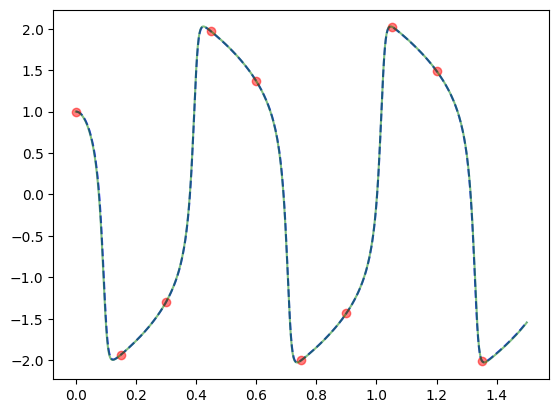

In [11]:
with torch.no_grad():
    t_test=torch.linspace(0,T_end,500).reshape(-1,1)
    y_pred=model(t_test)
    plt.plot(t_test,y_pred,'b--',alpha=0.8)
    plt.plot(t,y_out,'ro',alpha=0.5)
    plt.plot(time_numeric,y_exact,'g-',alpha=0.5)
    plt.show()